<a href="https://colab.research.google.com/github/Samjacob007/Time-Series/blob/main/Time_Series_Modelling_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Adjust the paths below according to your actual file location in Google Drive
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv', parse_dates=['date'], index_col='date')
amzn_df = pd.read_csv('/content/drive/MyDrive/AMZN.csv', parse_dates=['Date'], index_col='Date')

# Verify the data is loaded correctly
print(jj_df.head())
print(amzn_df.head())

            data
date            
1960-01-01  0.71
1960-04-01  0.63
1960-07-02  0.85
1960-10-01  0.44
1961-01-01  0.61
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-02-20  72.324501  74.438499  72.324501  73.417503  73.417503  129984000
2018-02-21  74.250000  75.174500  73.945999  74.146004  74.146004  126088000
2018-02-22  74.767998  75.126999  73.788002  74.266998  74.266998   97162000
2018-02-23  74.766998  75.000000  74.324997  75.000000  75.000000   88362000
2018-02-26  75.459999  76.141998  75.349998  76.097504  76.097504   99100000


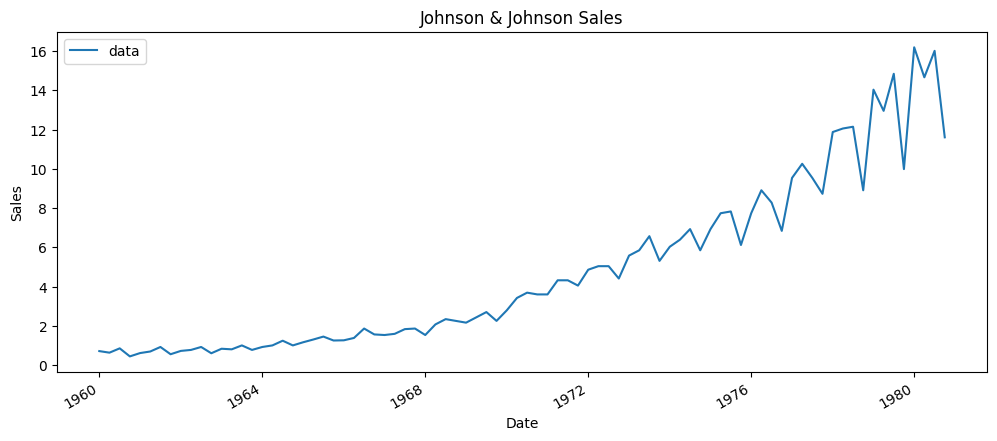

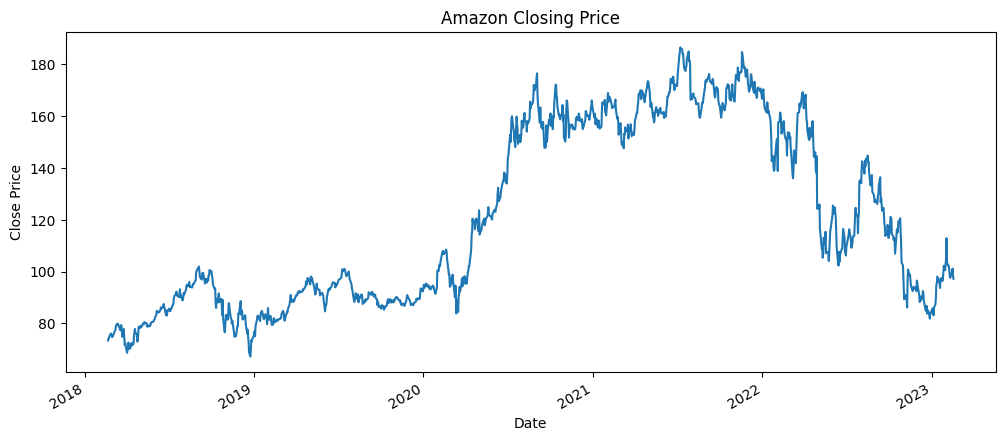

In [5]:
# Johnson & Johnson Sales data plot
jj_df.plot(title="Johnson & Johnson Sales", figsize=(12,5))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Amazon Share price data plot
amzn_df['Close'].plot(title="Amazon Closing Price", figsize=(12,5))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


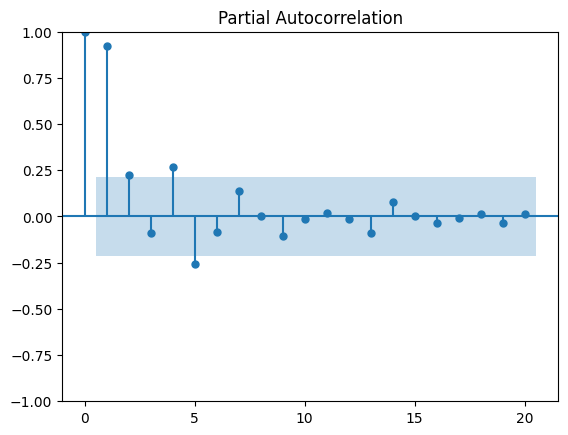

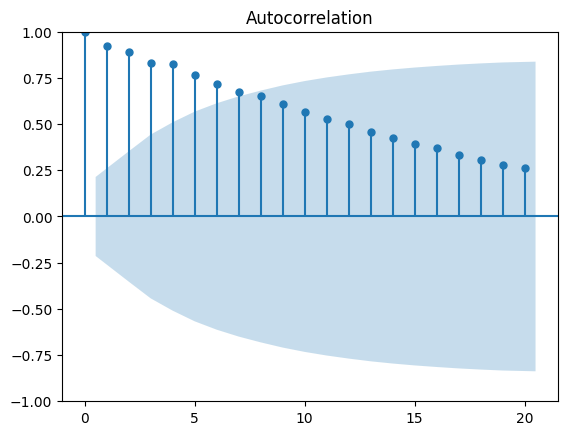

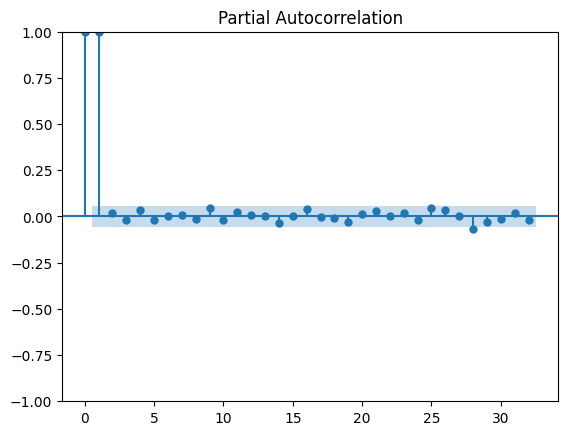

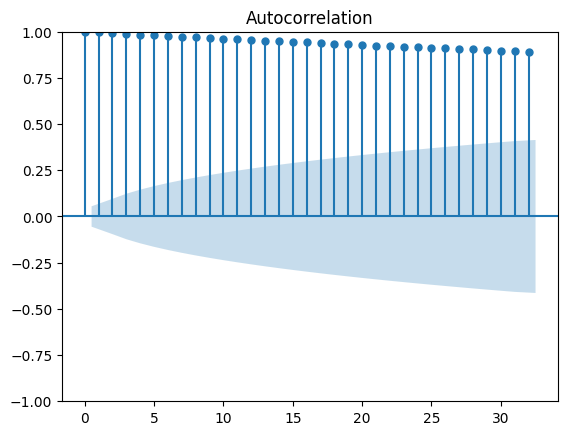

In [6]:
plot_pacf(jj_df['data']);
plot_acf(jj_df['data']);
plt.show()
plot_pacf(amzn_df['Close'])
plot_acf(amzn_df['Close'])
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on Johnson & Johnson sales data
ad_fuller_result = adfuller(jj_df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
 # Run ADF test on amazon
amzn_adf_result = adfuller(amzn_df['Close'])
print(f"ADF Statistic: {amzn_adf_result[0]}")
print(f"p-value: {amzn_adf_result[1]}")

ADF Statistic: 2.7420165734574744
p-value: 1.0
ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737


In [8]:
# Take the log
jj_df['data_log'] = np.log(jj_df['data'])

# Take the first difference of the log
jj_df['data_tr_1'] = jj_df['data_log'].diff()

# Display first 10 rows
print("🔹 Johnson & Johnson - Transformed Data (First 10 rows):")
print(jj_df.head(10))
# Take the log
amzn_df['Close_log'] = np.log(amzn_df['Close'])

# Take the first difference of the log
amzn_df['Close_tr_1'] = amzn_df['Close_log'].diff()

# Display first 10 rows
print("\n🔹 Amazon - Transformed Data (First 10 rows):")
print(amzn_df.head(10))

🔹 Johnson & Johnson - Transformed Data (First 10 rows):
            data  data_log  data_tr_1
date                                 
1960-01-01  0.71 -0.342490        NaN
1960-04-01  0.63 -0.462035  -0.119545
1960-07-02  0.85 -0.162519   0.299517
1960-10-01  0.44 -0.820981  -0.658462
1961-01-01  0.61 -0.494296   0.326684
1961-04-02  0.69 -0.371064   0.123233
1961-07-02  0.92 -0.083382   0.287682
1961-10-01  0.55 -0.597837  -0.514455
1962-01-01  0.72 -0.328504   0.269333
1962-04-02  0.77 -0.261365   0.067139

🔹 Amazon - Transformed Data (First 10 rows):
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2018-02-20  72.324501  74.438499  72.324501  73.417503  73.417503  129984000   
2018-02-21  74.250000  75.174500  73.945999  74.146004  74.146004  126088000   
2018-02-22  74.767998  75.126999  73.788002  74.266998  74.266998   97162000   
2018-02-23  74.766998  75.000000  74.32499

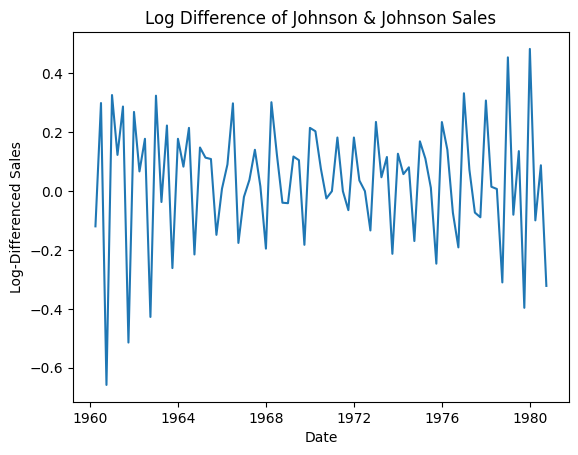

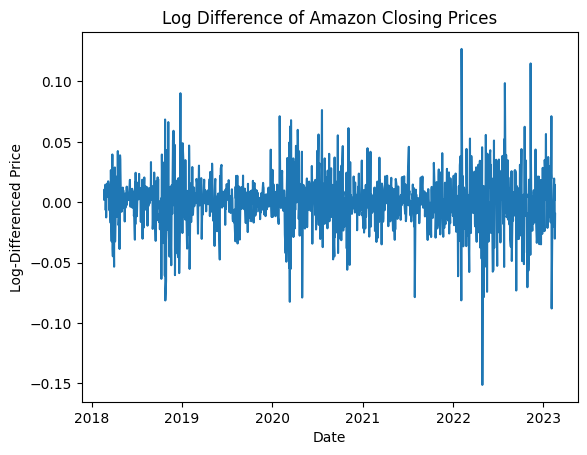

In [9]:
# Plot log difference of Johnson & Johnson sales
plt.plot(jj_df['data_tr_1'])
plt.title("Log Difference of Johnson & Johnson Sales")
plt.xlabel('Date')
plt.ylabel('Log-Differenced Sales')
plt.show()

# Plot log difference of Amazon closing prices
plt.plot(amzn_df['Close_tr_1'])
plt.title("Log Difference of Amazon Closing Prices")
plt.xlabel('Date')
plt.ylabel('Log-Differenced Price')
plt.show()


In [10]:
# Re-run ADF test on log-differenced JJ data
ad_fuller_result = adfuller(jj_df['data_tr_1'][1:])  # skip the first NaN
print("🔹 ADF Test - Johnson & Johnson (log difference):")
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# Re-run ADF test on log-differenced Amazon data
ad_fuller_result = adfuller(amzn_df['Close_tr_1'][1:])  # skip the first NaN
print("\n🔹 ADF Test - Amazon (log difference):")
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

🔹 ADF Test - Johnson & Johnson (log difference):
ADF Statistic: -4.317043945811837
p-value: 0.00041497314044406584

🔹 ADF Test - Amazon (log difference):
ADF Statistic: -36.639832812749425
p-value: 0.0


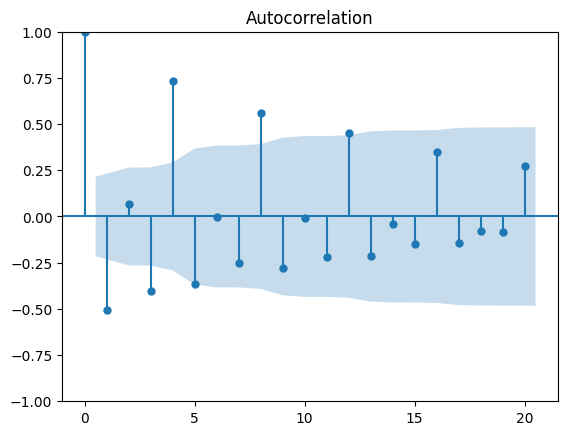

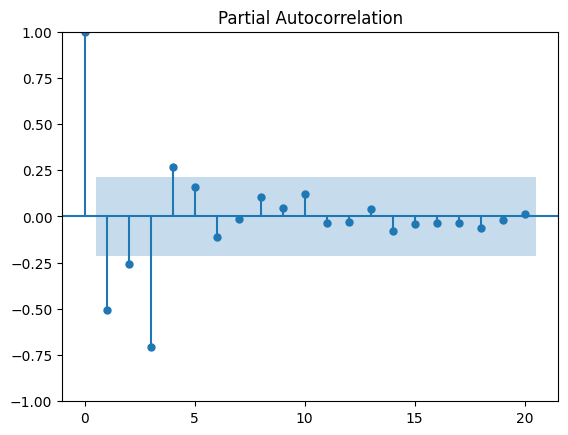

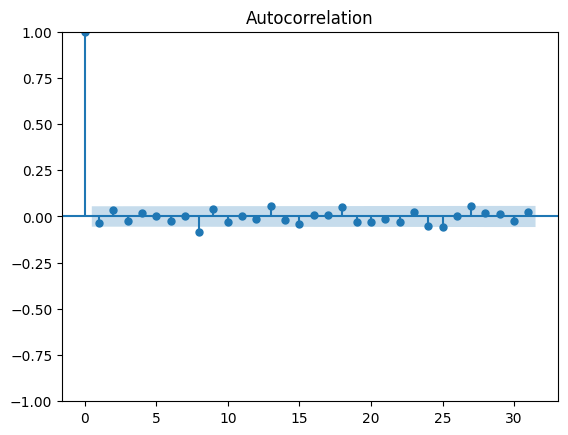

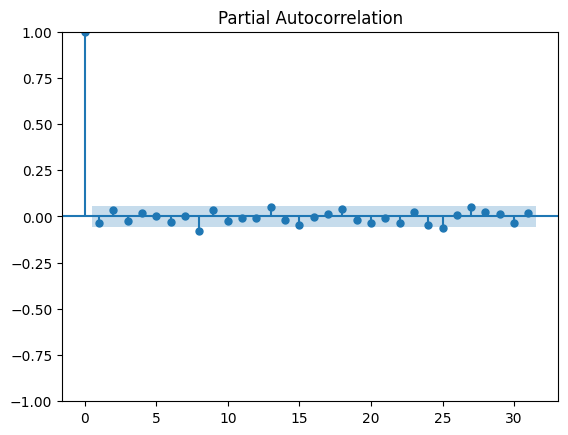

In [11]:
# Plot ACF and PACF for log-differenced Johnson & Johnson sales
plot_acf(jj_df['data_tr_1'][1:])
plot_pacf(jj_df['data_tr_1'][1:])
plt.show()

# Plot ACF and PACF for log-differenced Amazon closing price
plot_acf(amzn_df['Close_tr_1'][1:])
plot_pacf(amzn_df['Close_tr_1'][1:])
plt.show()

In [12]:
# Define ARIMA model (p=3, d=1, q=3) on original JJ data
model = ARIMA(jj_df['data'], order=(3,1,3))

# Fit the model
model_fit = model.fit()

# Print model summary
print("🔹 ARIMA Model Summary - Johnson & Johnson:")
print(model_fit.summary())


# Define ARIMA model (example: p=3, d=1, q=3) on original Amazon data
model_amzn = ARIMA(amzn_df['Close'], order=(3,1,3))

# Fit the model
model_amzn_fit = model_amzn.fit()

# Print model summary
print("\n🔹 ARIMA Model Summary - Amazon:")
print(model_amzn_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


🔹 ARIMA Model Summary - Johnson & Johnson:
                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -76.286
Date:                Tue, 08 Apr 2025   AIC                            166.572
Time:                        21:52:38   BIC                            183.504
Sample:                             0   HQIC                           173.374
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0311      0.036    -28.924      0.000      -1.101      -0.961
ar.L2         -1.0273      0.043    -23.892      0.000      -1.112      -0.943
ar.L3    

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u


🔹 ARIMA Model Summary - Amazon:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3055.652
Date:                Tue, 08 Apr 2025   AIC                           6125.305
Time:                        21:52:40   BIC                           6161.266
Sample:                             0   HQIC                          6138.820
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7321      0.062    -11.836      0.000      -0.853      -0.611
ar.L2          0.6699      0.102      6.538      0.000       0.469       0.871
ar.L3          0.92

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC

        order_list - list with (p, d, q) tuples
        endog - the observed variable, in this case data['data']
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            #model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
        except:
            continue

        aic = model_fit.aic
        results.append([order, model_fit.aic])
        #print(order)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [14]:
from itertools import product

# Set the range for p and q (0 to 7), and d is fixed at 1
ps = range(0, 8, 1)
qs = range(0, 8, 1)
d = 1

# Create combinations of p and q
parameters = product(ps, qs)  # e.g., (0,0), (0,1), ..., (7,7)
parameters_list = list(parameters)

# Insert d = 1 as the second element in each tuple
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)  # Now becomes (p, d, q)
    order_list.append(tuple(each))  # Convert back to tuple

# Check first 10 orders
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [23]:
# Call optimize_ARIMA with the correct DataFrame and column
result_df = optimize_ARIMA(jj_df['data'], order_list)

# Display the top results (lowest AIC first)
result_df.head()



  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
  2%|▏         | 1/64 [00:00<00:09,  6.45it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.297318
1,"(4, 1, 6)",115.859233
2,"(7, 1, 1)",116.050450
3,"(5, 1, 3)",116.536224
4,"(5, 1, 4)",117.242599


In [25]:

# Define and fit the best ARIMA model using the correct variable name
best_model = ARIMA(jj_df['data'], order=(6, 1, 3))

best_model_fit = best_model.fit()

# Optionally, view the model summary
print(best_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.649
Date:                Tue, 08 Apr 2025   AIC                            115.297
Time:                        22:05:10   BIC                            139.486
Sample:                             0   HQIC                           125.015
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4733      0.127    -11.640      0.000      -1.721      -1.225
ar.L2         -0.7728      0.148     -5.235      0.000      -1.062      -0.484
ar.L3          0.0382      0.063      0.610      0.5

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


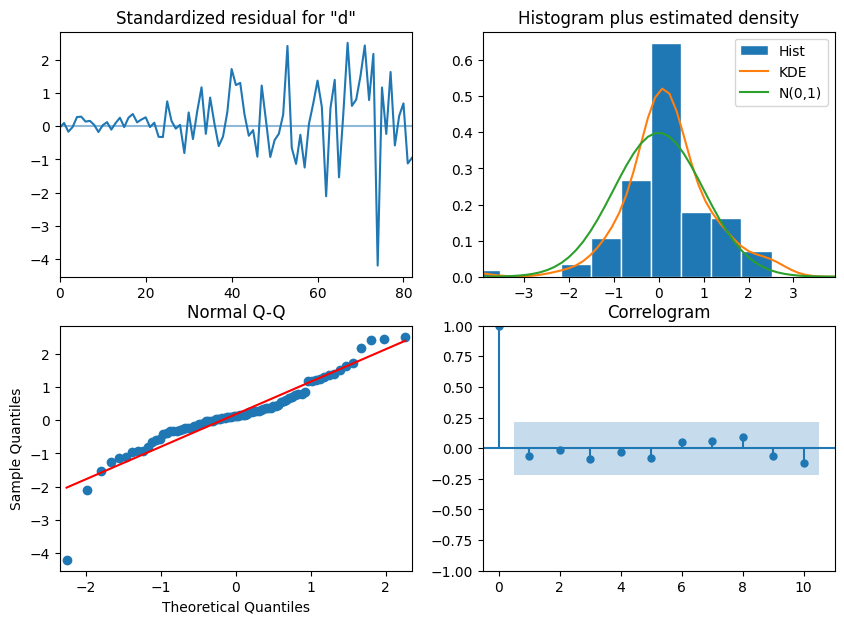

In [26]:
best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [28]:
# Use the correct DataFrame
test_data = jj_df['data']

# Get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# Get the predictions and residuals
predictions = best_model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions


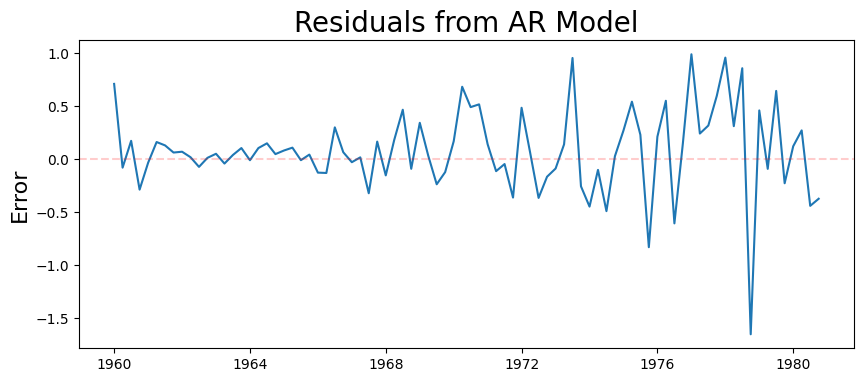

In [29]:
# plot the residuals

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [30]:
# Assess the root mean square of the residuals

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.3999081195935732


Text(0.5, 0, 'Month Number')

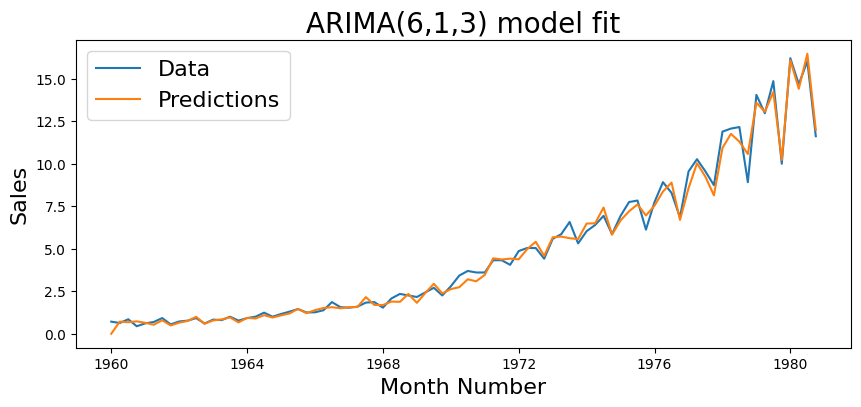

In [31]:
# Plot the model prediction against the data

plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('ARIMA(6,1,3) model fit', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month Number', fontsize=16)

In [32]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1,
            'corr':corr, 'minmax':minmax})

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def forecast_accuracy(y_pred, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-15-8e7f0460112f>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  jj_forecast_index = pd.date_range(start=jj_df.index[-1], periods=24, freq='M')


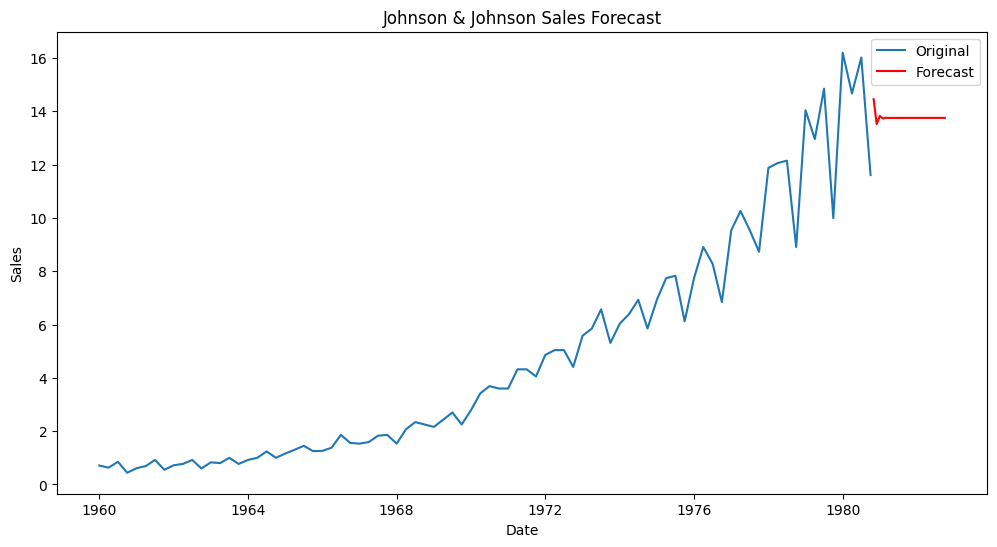

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
<ipython-input-15-8e7f0460112f>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  amzn_forecast_index = pd.date_range(start=amzn_df.index[-1], periods=24, freq='M')


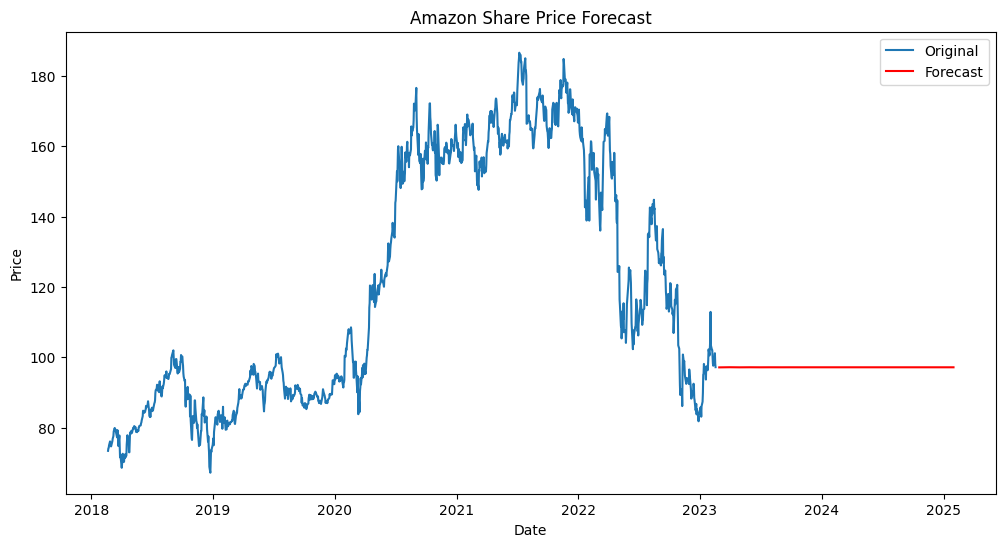

In [ ]:
# Johnson & Johnson sales forecast (corrected column name)
jj_forecast = jj_model.get_forecast(steps=24)
jj_forecast_index = pd.date_range(start=jj_df.index[-1], periods=24, freq='M')
jj_forecast_mean = jj_forecast.predicted_mean

plt.figure(figsize=(12,6))
plt.plot(jj_df['data'], label='Original')  # <-- corrected here
plt.plot(jj_forecast_index, jj_forecast_mean, label='Forecast', color='red')
plt.t()

# Amazon closing price forecast
amzn_forecast = amzn_model.get_forecast(steps=24)
amzn_foreitle('Johnson & Johnson Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.showcast_index = pd.date_range(start=amzn_df.index[-1], periods=24, freq='M')
amzn_forecast_mean = amzn_forecast.predicted_mean

plt.figure(figsize=(12,6))
plt.plot(amzn_df['Close'], label='Original')
plt.plot(amzn_forecast_index, amzn_forecast_mean, label='Forecast', color='red')
plt.title('Amazon Share Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

scaler = MinMaxScaler()

# Scaling data
jj_scaled = scaler.fit_transform(jj_df)

# Creating sequences
def create_sequences(data, seq_length=12):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:(i+seq_length)])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(jj_scaled, seq_length)

# Splitting train/test data
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Fit model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Prediction
y_pred_lstm = model_lstm.predict(X_test)

# Inverse transform predictions
y_pred_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

# Evaluation
print('RMSE:', sqrt(mean_squared_error(y_test_inv, y_pred_inv)))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0693
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0408 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0413 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0282
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0160 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0091
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0079
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012    
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt


In [ ]:
# Extracting the correct column 'data'
jj_values = jj_df[['data']].values

# Scaling
scaler = MinMaxScaler()
jj_scaled = scaler.fit_transform(jj_values)


In [ ]:
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(jj_scaled, seq_length)


In [ ]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Ensure correct shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Fit LSTM model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Predict using LSTM
y_pred_lstm = model_lstm.predict(X_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0746
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0547 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0485
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0353
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0279 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0225 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0147
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0102
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0083 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0072 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0065
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0054
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0039 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0033
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0021 
Epoch 16/50
4/4 ━━━━━━━━━━━

In [ ]:
# Inverse scaling for predictions
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)


LSTM RMSE: 2.1307897986044693


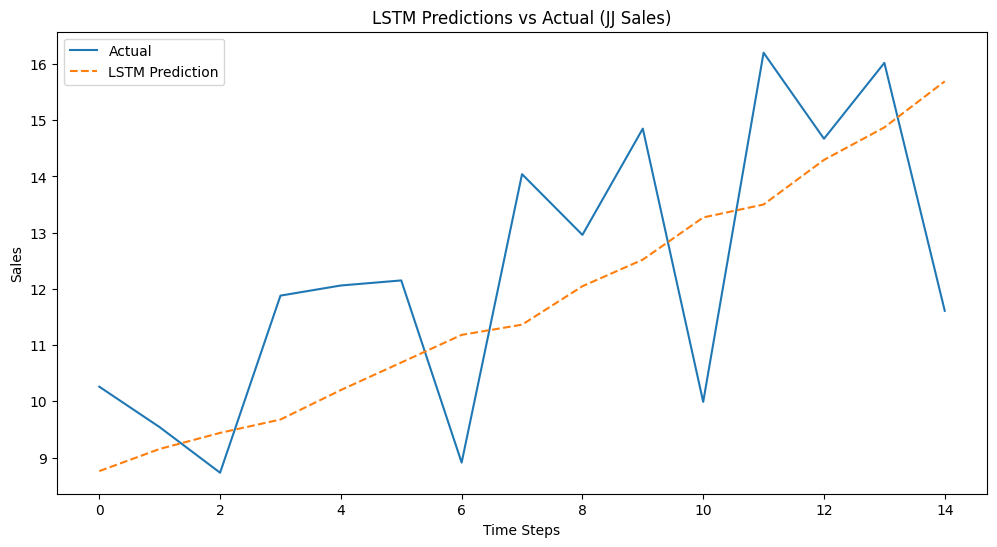

In [ ]:
# Evaluation Metrics
lstm_rmse = sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
print('LSTM RMSE:', lstm_rmse)

# Plotting Actual vs Prediction
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_lstm_inv, label='LSTM Prediction', linestyle='--')
plt.title('LSTM Predictions vs Actual (JJ Sales)')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU

# Define GRU model
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', input_shape=(seq_length, 1)))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

# Fit GRU model
model_gru.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0493
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0386 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0195
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0164
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0083
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0084
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0075
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0066
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0050
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0039 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0030
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0026
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0016
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0013
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━

In [ ]:
# Predicting test set results with GRU
y_pred_gru = model_gru.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


In [ ]:
# Inverse scaling for predictions
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)
y_test_inv = scaler.inverse_transform(y_test)


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate evaluation metrics
gru_rmse = sqrt(mean_squared_error(y_test_inv, y_pred_gru_inv))
print('GRU RMSE:', gru_rmse)


GRU RMSE: 2.392318701294724


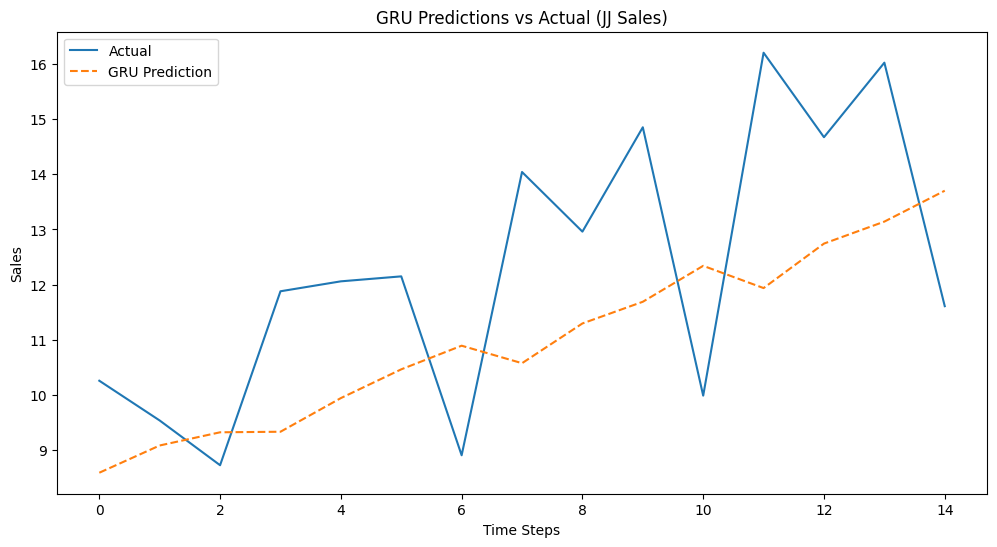

In [ ]:
import matplotlib.pyplot as plt

# Plot Actual vs GRU Prediction
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_gru_inv, label='GRU Prediction', linestyle='--')
plt.title('GRU Predictions vs Actual (JJ Sales)')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
def forecast_future(model, last_sequence, steps=24):
    future_predictions = []
    current_seq = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(current_seq.reshape(1, -1, 1))[0, 0]
        future_predictions.append(pred)
        current_seq = np.append(current_seq[1:], pred)
    return np.array(future_predictions)

# Last sequence from your data
last_sequence = X_test[-1]

# Forecast next 24 months using LSTM
future_lstm = forecast_future(model_lstm, last_sequence, steps=24)
future_lstm_inv = scaler.inverse_transform(future_lstm.reshape(-1, 1))

# Forecast next 24 months using GRU
future_gru = forecast_future(model_gru, last_sequence, steps=24)
future_gru_inv = scaler.inverse_transform(future_gru.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━

In [ ]:
jj_forecast_arima = jj_model.get_forecast(steps=24).predicted_mean.values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
future_dates = pd.date_range(start=jj_df.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')


<ipython-input-33-29fb976c2f05>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=jj_df.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')


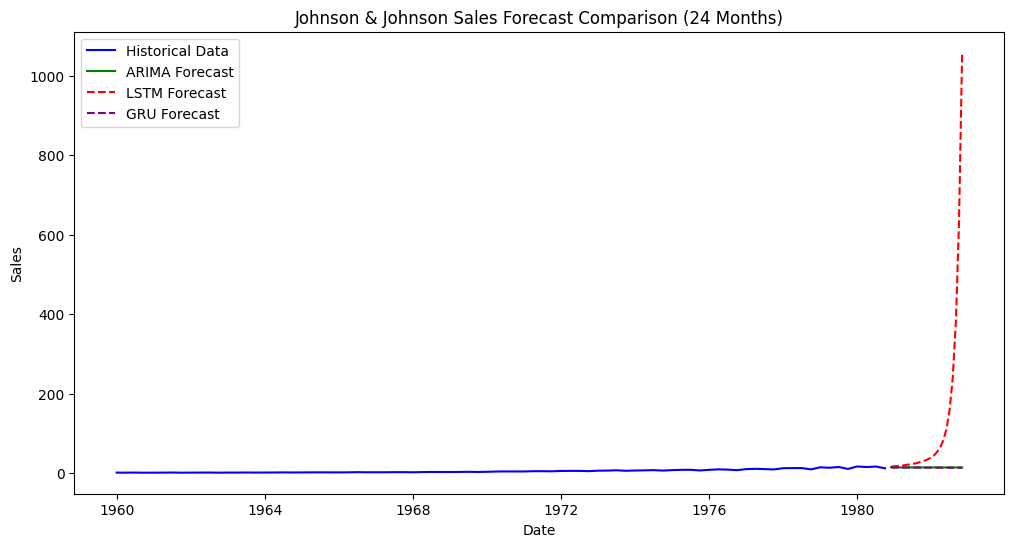

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(jj_df.index, jj_df['data'], label='Historical Data', color='blue')
plt.plot(future_dates, jj_forecast_arima, label='ARIMA Forecast', color='green')
plt.plot(future_dates, future_lstm_inv, label='LSTM Forecast', color='red', linestyle='--')
plt.plot(future_dates, future_gru_inv, label='GRU Forecast', color='purple', linestyle='--')

plt.title('Johnson & Johnson Sales Forecast Comparison (24 Months)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}


In [ ]:
# LSTM Evaluation
metrics_lstm = evaluate_metrics(y_test_inv, y_pred_lstm_inv)

# GRU Evaluation
metrics_gru = evaluate_metrics(y_test_inv, y_pred_gru_inv)


In [ ]:
# Define test set length based on y_test_inv length
arima_test_length = len(y_test_inv)

# Actual test data from JJ original dataset
jj_test_actual = jj_df['data'][-arima_test_length:]

# ARIMA predictions for the test period
jj_arima_test_pred = jj_model.predict(start=jj_test_actual.index[0], end=jj_test_actual.index[-1])

# Evaluate ARIMA
metrics_arima = evaluate_metrics(jj_test_actual, jj_arima_test_pred)


In [ ]:
print("Evaluation Metrics Comparison:\n")

print("🔹 LSTM Metrics:")
for k, v in metrics_lstm.items():
    print(f"{k}: {v:.4f}")

print("\n🔹 GRU Metrics:")
for k, v in metrics_gru.items():
    print(f"{k}: {v:.4f}")

print("\n🔹 ARIMA Metrics:")
for k, v in metrics_arima.items():
    print(f"{k}: {v:.4f}")


Evaluation Metrics Comparison:

🔹 LSTM Metrics:
RMSE: 2.1308
MAE: 1.8598
MAPE: 15.6312

🔹 GRU Metrics:
RMSE: 2.3923
MAE: 2.1890
MAPE: 17.3736

🔹 ARIMA Metrics:
RMSE: 2.3334
MAE: 2.1787
MAPE: 18.1172
